The goal of this project is to create a model to predict churn in customers for SyriaTel, a telecom company. If customer churn can be identified before it happens, a retention strategy can be implemented before they churn. According to SyriaTel, the estimated lost profit due to churn is ~\\$240/customer and reaching out to a customer about to churn is ~⅓ effective, so the average profit from reaching out to a customer about to churn is ~\\$80. The cost of outreach is ~\\$20/customer. The cost of simply reaching out to all customers and retaining ⅓ of those about to churn would be a net loss of \\$28,000, so accurate prediction of customers likely to churn will be extremely valuable here. If one customer is correctly identified out of every four customers flagged for potential churn, this project will be net neutral. The model will seek a much higher bar than that, however, and will optimize for maximum profit.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [2]:
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

In [3]:
df.nunique()

state                       51
account length             212
area code                    3
phone number              3333
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

Some observations:
* These are all unique phone numbers, no duplicates to deal with.
* There are many states represented, but only 3 area codes, all in the San Francisco Bay Area.
* Churn, the result we would like to model, has 2 unique values, i.e.: it is a binary result.

In [4]:
print('Number of customers: ',len(df))
print('Number of churning customers: ',df['churn'].value_counts()[1])
print('Churn rate: ',round(df['churn'].value_counts()[1]/3333,3))

Number of customers:  3333
Number of churning customers:  483
Churn rate:  0.145


In [5]:
# Cost of simply reaching out to all customers
df['churn'].value_counts()[1]*80-3333*20

-28020

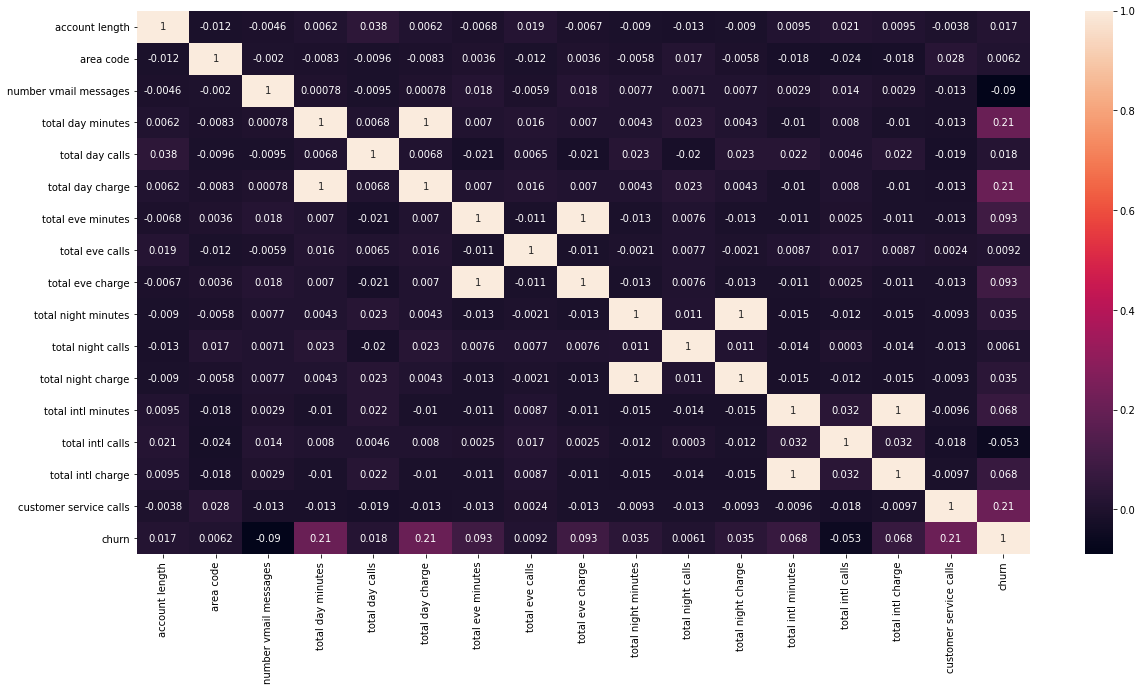

In [6]:
#Check correlation between features
corrmat = df.corr()

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True);

In [7]:
print(f"""Correlation between day minutes and charge: {df['total day minutes'].corr(df['total day charge'])}""")
print(f"""Correlation between eve minutes and charge: {df['total eve minutes'].corr(df['total eve charge'])}""")
print(f"""Correlation between night minutes and charge: {df['total night minutes'].corr(df['total night charge'])}""")
print(f"""Correlation between intl minutes and charge: {df['total intl minutes'].corr(df['total intl charge'])}""")

Correlation between day minutes and charge: 0.9999999521903998
Correlation between eve minutes and charge: 0.9999997760198508
Correlation between night minutes and charge: 0.9999992148758774
Correlation between intl minutes and charge: 0.9999927417510311


In [8]:
# There is almost perfect correlation between minutes and charges, implying a flat per-minute rate. Only one
# of each is needed, so the other will be dropped.
df_filtered = df.drop(['total day charge','total eve charge','total night charge','total intl charge'],axis=1)

In [9]:
# One hot encoding for categorical columns
categorical = ['state','area code', 'international plan', 'voice mail plan','churn']
df_encoded = pd.get_dummies(df_filtered, columns=categorical, drop_first=True)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score

In [11]:
# Set seed for random states to be consistent throughout
SEED=42

# Define the X and y for the model
X = df_encoded.drop(['churn_True','phone number'], axis=1)
y = df_encoded.churn_True

# Train test split from full data.
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X,y, random_state=SEED, train_size=0.8)

# Further split the training data set for model selection and hypertuning parameters. The X_train/y_train set will 
# train these intermediate models, which will be evaulated using X_test/y_test. 
X_train, X_test, y_train, y_test = train_test_split(X_train_final,y_train_final, random_state=SEED, train_size=0.75)

# Once all of the parameters are established,the X_train_final/y_train_final and X_test_final/y_test_final sets will
# be used to train and test the final model.

In [12]:
# This will be the function I use to calculate the dollar value of the current model if it is applied as-is.
revenue_recaptured = 80
outreach_cost = 20

# This function will take in a model name and a set of X and y test values. It will print the profit(or loss) that would 
# have been had if this model had been implemented to these customers. It also prints the recall and precision.

def model_eval(model_name,X_test,y_test):
    y_hat_test = model_name.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat_test)
    rec_score = recall_score(y_test,y_hat_test)
    prec_score = precision_score(y_test, y_hat_test)
    profit_loss = round(revenue_recaptured*conf_mat[1,1]-outreach_cost*(conf_mat[0,1]+conf_mat[1,1]),2)
    print(f'Profit(loss): ${profit_loss}')
    print(f'Recall: {round(rec_score,3)}')
    print(f'Precision: {round(prec_score,3)}')    
    return(profit_loss)

In [13]:
# Creating a version of the evaluation function that doesn't print the result, to be used to generate data points for graphs

def model_eval_no_print(model_name,X_test,y_test):
    y_hat_test = model_name.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat_test)
    rec_score = recall_score(y_test,y_hat_test)
    profit_loss = round(revenue_recaptured*conf_mat[1,1]-outreach_cost*(conf_mat[0,1]+conf_mat[1,1]),2)
   
    return(profit_loss)

Profit(loss): $1260
Recall: 0.257
Precision: 0.634


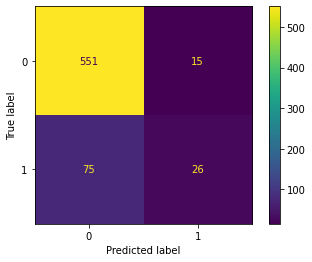

In [14]:
# Create the baseline logistic regression model
logreg_base = LogisticRegression(random_state=SEED, fit_intercept=False, solver='liblinear')
logreg_base.fit(X_train.values,y_train) # added .values to handle labeling error
model_eval(logreg_base,X_test.values,y_test);

# Print the confusion matrix
y_hat_test = logreg_base.predict(X_test.values)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

In [15]:
# Scaling everything to a 0-1 range

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final_scaled = scaler.transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)

Profit(loss): $1080
Recall: 0.228
Precision: 0.605


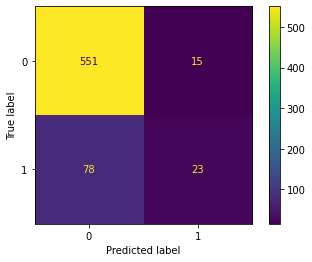

In [16]:
logreg_scaled = LogisticRegression(random_state=SEED,fit_intercept=False, solver='liblinear')
logreg_scaled.fit(X_train_scaled,y_train)
model_eval(logreg_scaled,X_test_scaled,y_test);

y_hat_test = logreg_scaled.predict(X_test_scaled)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

Scaling didn't improve the results of the model by any of these measures.

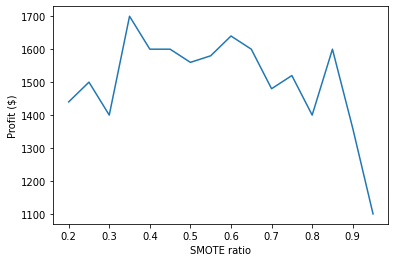

In [17]:
# This will loop through a range of ratios to feed into the SMOTE function to analyze the effect of oversampling the 
# churning customers to improve the sensitivity of the model. The results will be plotted to visualize the optimum value.

ratios = np.arange(.2,1,.05)
dollars_smote = []

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train.values, y_train) 

    logreg = LogisticRegression(fit_intercept=False, solver ='liblinear')
    logreg.fit(X_train_resampled, y_train_resampled)
    result = model_eval_no_print(logreg,X_test.values,y_test)
    dollars_smote.append(result)
    
fig, ax = plt.subplots()
ax.plot(ratios,dollars_smote,label='Profit ($)')
ax.set_ylabel('Profit ($)')
ax.set_xlabel('SMOTE ratio')
plt.show();

Max occurs at 0.35 resampling rate with validation data.

Profit(loss): $1300
Recall: 0.347
Precision: 0.467


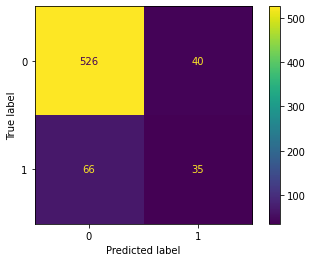

In [18]:
# Find the result of the using the optimum SMOTE ratio found above on the final test data.

smote = SMOTE(sampling_strategy=0.35, random_state=SEED)

X_train_final_resampled, y_train_final_resampled = smote.fit_resample(X_train_final_scaled, y_train_final) 

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final_scaled, y_train_final) 
logreg_resample = LogisticRegression(fit_intercept=False, solver ='liblinear')
logreg_resample.fit(X_train_final_resampled, y_train_final_resampled)

model_eval(logreg_resample,X_test_final_scaled,y_test_final)

y_hat_test = logreg_resample.predict(X_test_final_scaled)
conf_mat = confusion_matrix(y_test_final, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

This result of $1300 is an improvement over the baseline, but another model will be analyzed to see if it will be more profitable. 

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, roc_auc_score

Profit for entropy:
Profit(loss): $3520
Recall: 0.703
Precision: 0.657

Profit for gini:
Profit(loss): $3700
Recall: 0.733
Precision: 0.667

Profit for log loss:
Profit(loss): $3520
Recall: 0.703
Precision: 0.657


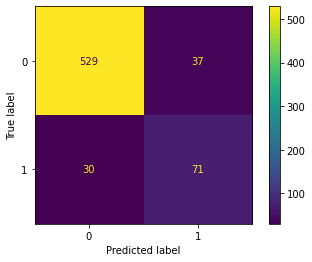

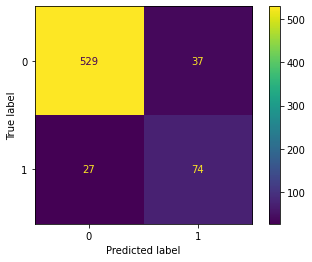

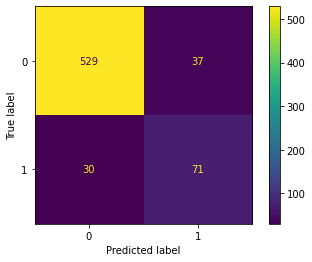

In [20]:
# This will compare three different criterion types for the decision tree classifier.

clf = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
clf.fit(X_train, y_train)
print('Profit for entropy:')
model_eval(clf,X_test,y_test);
y_hat_test = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

clf_g = DecisionTreeClassifier(criterion='gini',random_state=SEED)
clf_g.fit(X_train, y_train)
print('\nProfit for gini:')
model_eval(clf_g,X_test,y_test);
y_hat_test = clf_g.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

clf_ll = DecisionTreeClassifier(criterion='log_loss',random_state=SEED)
clf_ll.fit(X_train, y_train)
y_hat_test = clf_ll.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();
print('\nProfit for log loss:')
model_eval(clf_ll,X_test,y_test);

The model that uses gini as the criterion is slightly better.


Profit for gini:
Profit(loss): $3700
Recall: 0.733
Precision: 0.667


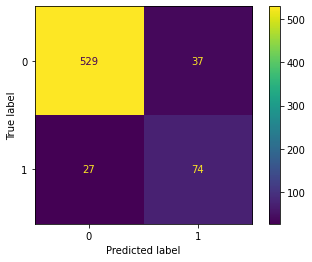

In [21]:
# Checking to see if scaling the factors will be helpful.
clf_scaled = DecisionTreeClassifier(criterion='gini',random_state=SEED)
clf_scaled.fit(X_train_scaled, y_train)
print('\nProfit for gini:')
model_eval(clf_scaled,X_test_scaled,y_test);
y_hat_test = clf_scaled.predict(X_test_scaled)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

No effect from scaling

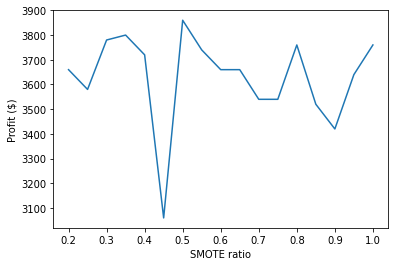

In [22]:
# As above, looping through a range of ratios to determine the optimum SMOTE ratio.

ratios = np.arange(.2,1.001,.05)
dollars_smote_tree = []
for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=round(ratio,3), random_state=SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train.values, y_train) 
    X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)
    clf_resamp_temp = DecisionTreeClassifier(criterion='gini',random_state=SEED)
    clf_resamp_temp.fit(X_train_resampled, y_train_resampled)
    result = model_eval_no_print(clf_resamp_temp,X_test.values,y_test)
    dollars_smote_tree.append(result)
    
fig, ax = plt.subplots()
ax.plot(ratios,dollars_smote_tree,label='Profit ($)')
ax.set_ylabel('Profit ($)')
ax.set_xlabel('SMOTE ratio')
plt.show();

In [23]:
# Get the results for the optimum ratio.
smote = SMOTE(sampling_strategy=.5, random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.values, y_train) 
clf_resamp_temp = DecisionTreeClassifier(criterion='gini',random_state=SEED)
clf_resamp_temp.fit(X_train_resampled, y_train_resampled)
model_eval(clf_resamp_temp,X_test.values, y_test);

Profit(loss): $3860
Recall: 0.743
Precision: 0.701


Slight improvement from oversampling.

In [24]:
# This function will be used to automate the hypertuning. It will take in the parameter name, X and y data, and information
# to create the range of values to try. Then it plots a curve to help visualize the optimum value.

def hypertuning(parameter,X_train,y_train,X_test,y_test,start,stop,increment):
    parameter_range = np.arange(start,stop,increment)
    temp_range=[]
    profit=[]
    for i in parameter_range:
        param_name = parameter
        param_value = i
        
        # With assistance from ChatGPT - it gave me this method to set parameter names using variables so I can 
        # call this function with any parameter I want and have it run through a range of parameters.
        kwargs = {param_name: param_value, 'random_state':SEED,'criterion':'gini'}
        dt_temp = DecisionTreeClassifier(**kwargs)
        # Thanks ChatGPT!!
        
        dt_temp.fit(X_train,y_train)
        y_pred_train = dt_temp.predict(X_train)
        y_pred_test = dt_temp.predict(X_test)
        temp_range.append(i)
        profit.append(model_eval_no_print(dt_temp,X_test,y_test))
        
    fig, ax1 = plt.subplots()
    ax1.plot(temp_range,profit,label='Profit',color='g')
    ax1.set_ylabel('Profit ($)')
    ax1.set_xlabel(parameter)
    lines, labels = ax1.get_legend_handles_labels()
    plt.show();

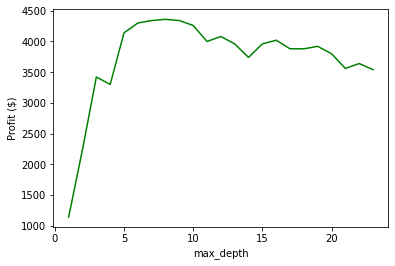

In [25]:
hypertuning("max_depth",X_train_resampled,y_train_resampled,X_test.values,y_test,1,24,1)

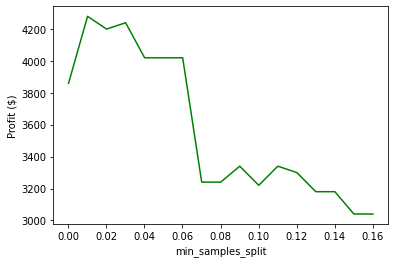

In [26]:
hypertuning("min_samples_split",X_train_resampled,y_train_resampled,X_test.values,y_test,0.0001,.17,.01)

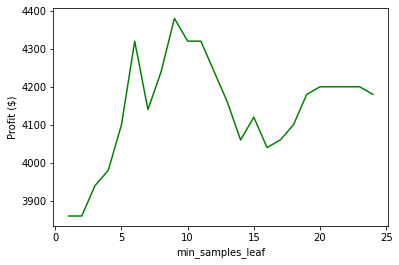

In [27]:
hypertuning("min_samples_leaf",X_train_resampled,y_train_resampled,X_test.values,y_test,1,25,1)

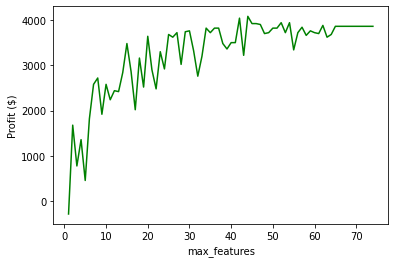

In [28]:
hypertuning("max_features",X_train_resampled,y_train_resampled,X_test.values,y_test,1,75,1)

Profit(loss): $4140
Recall: 0.733
Precision: 0.831


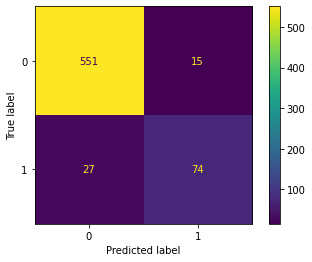

In [29]:
# Creating a model using the optimum parameters (in this case, using all of the parameters together wasn't as good as 
# using min_samples_leaf by itself, so the only the best result is shown.)

dt_hyper = DecisionTreeClassifier(random_state=SEED,criterion='gini',min_samples_leaf=7)
dt_hyper.fit(X_train_resampled,y_train_resampled)
model_eval(dt_hyper,X_test.values,y_test)
y_hat_hyper = dt_hyper.predict(X_test.values)
conf_mat = confusion_matrix(y_test, y_hat_hyper)
ConfusionMatrixDisplay(conf_mat).plot();

Profit(loss): $4180
Recall: 0.743
Precision: 0.824


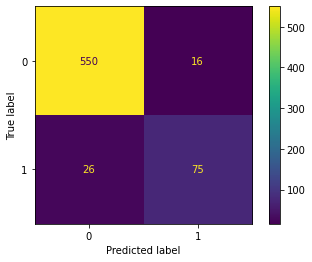

In [30]:
# Finally, running the model on the final test data, which was segregated in one of the first steps, to determine the
# effectiveness of the tuned model on a completely unseen data set.

dt_final = DecisionTreeClassifier(random_state=SEED,criterion='gini',min_samples_leaf=7)
dt_final.fit(X_train_resampled,y_train_resampled)
model_eval(dt_final,X_test_final.values,y_test_final)
y_hat_test = dt_final.predict(X_test_final.values)
conf_mat = confusion_matrix(y_test_final, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

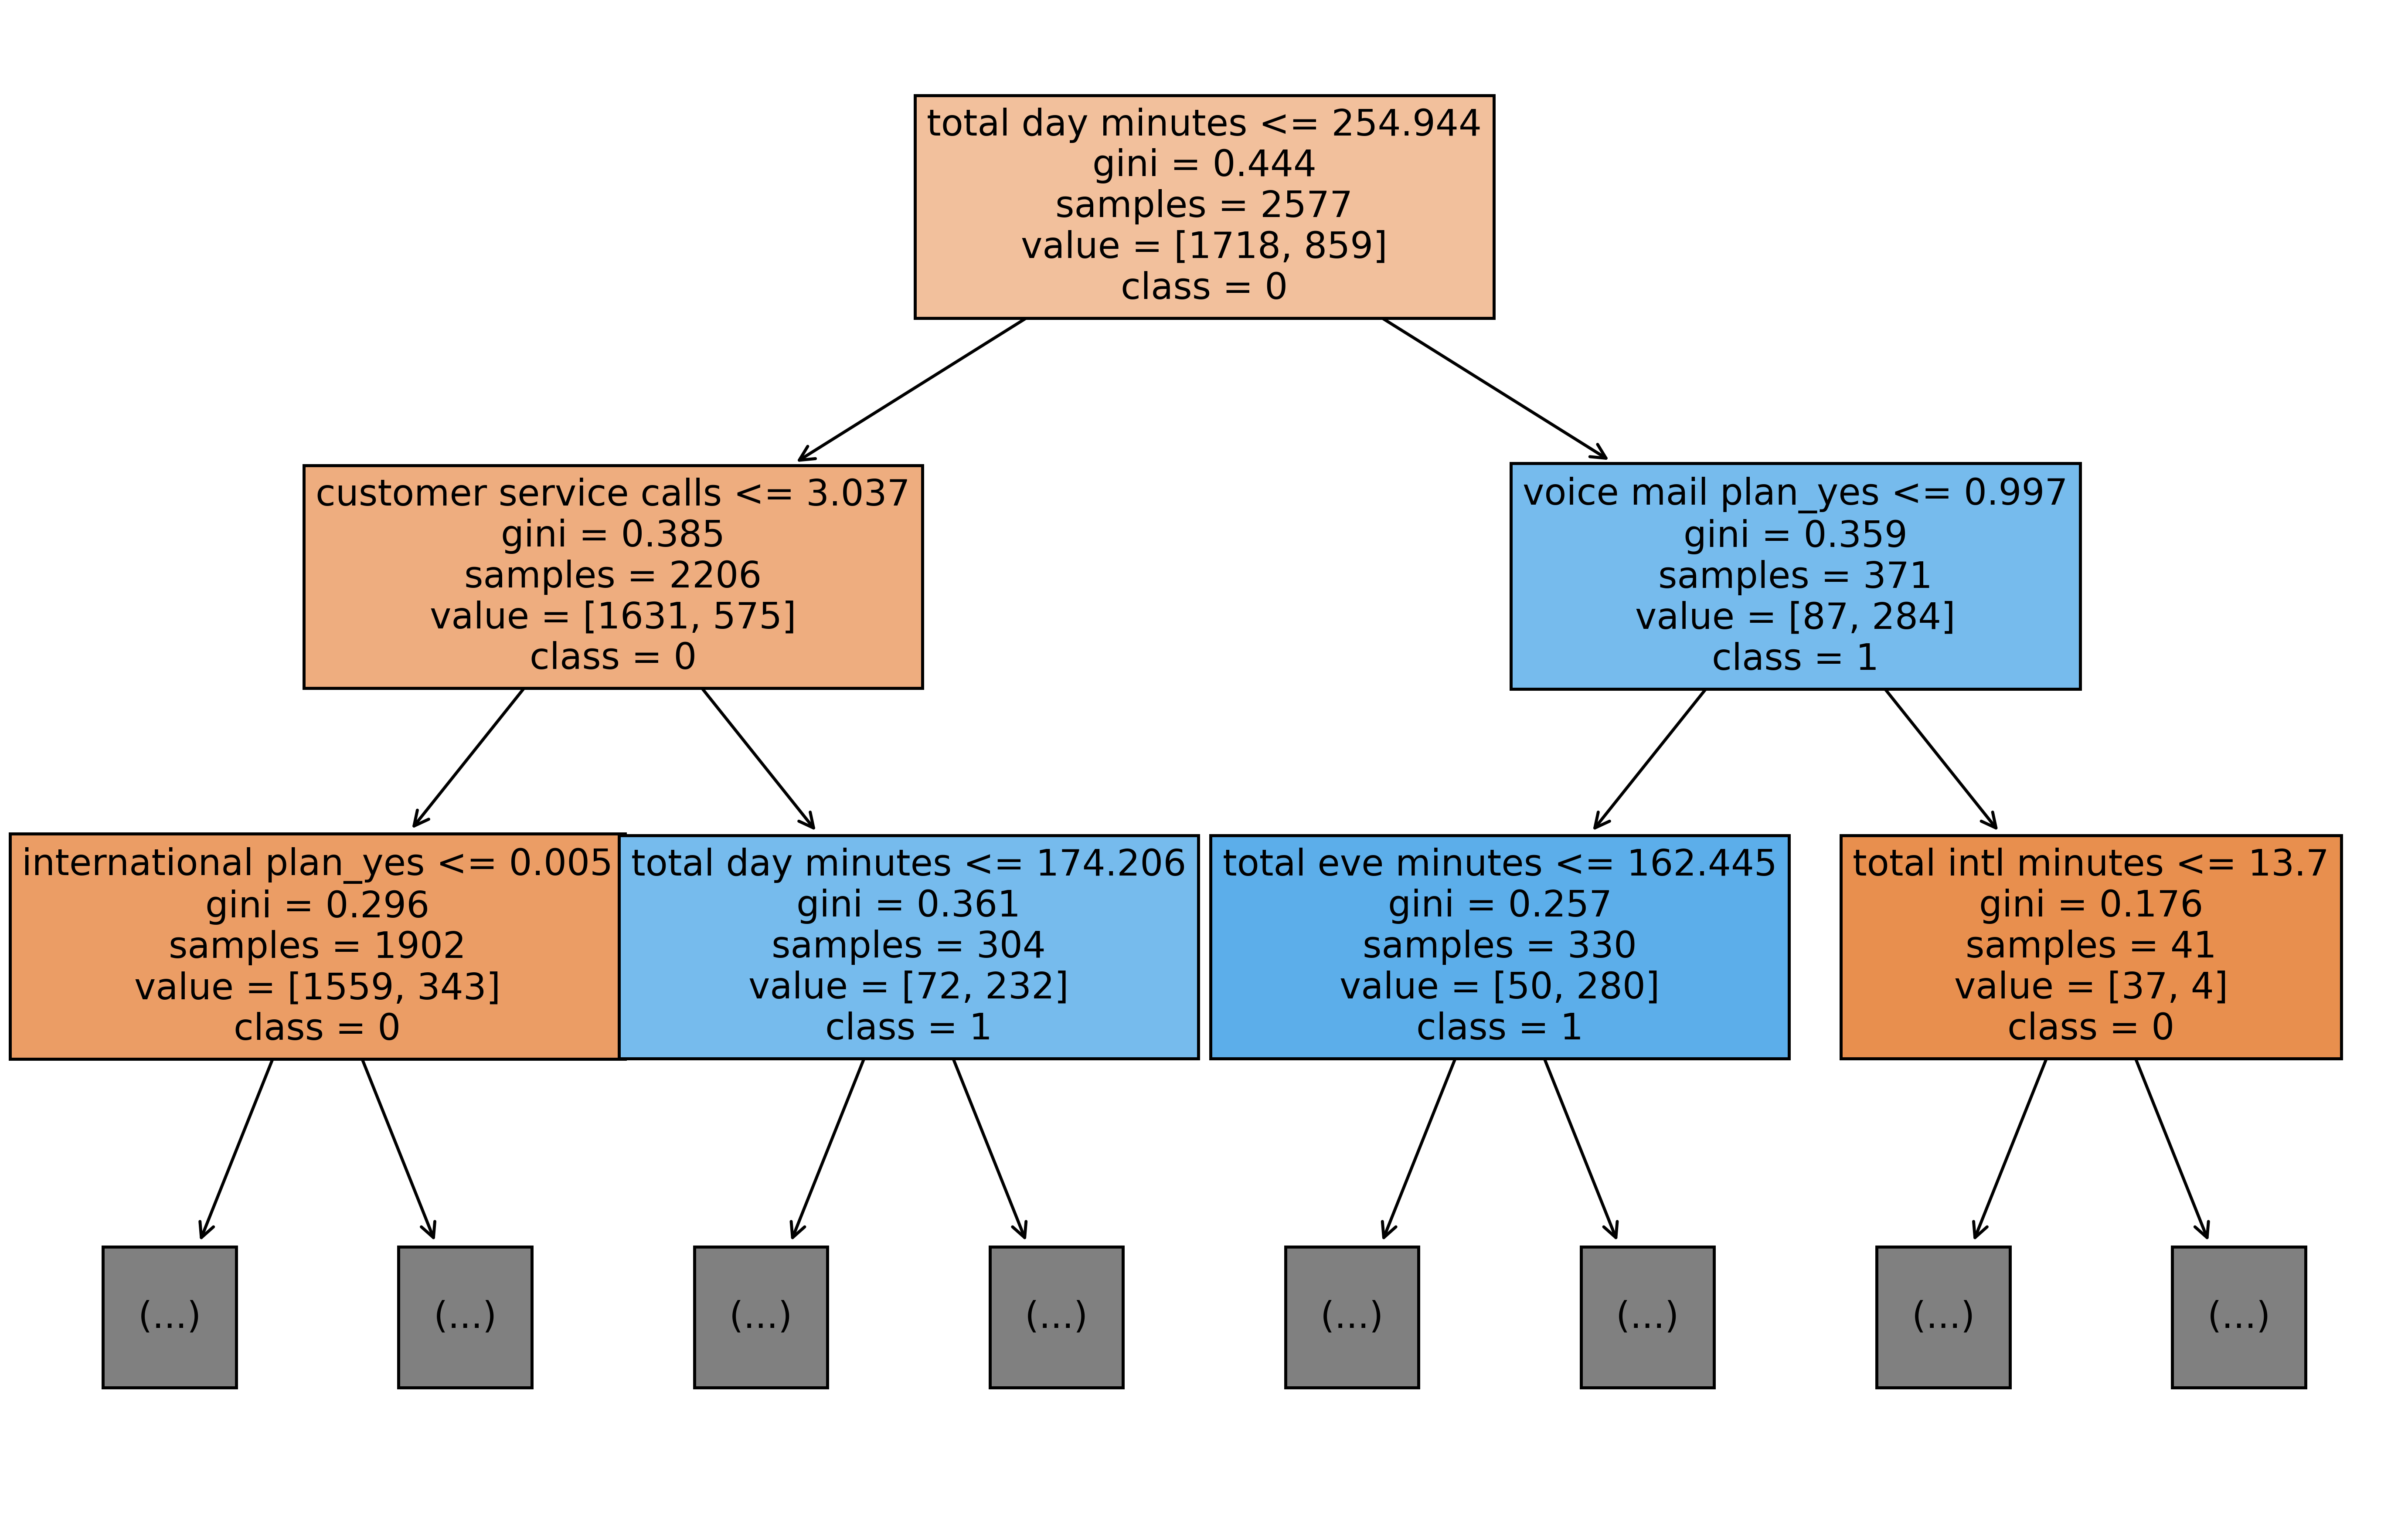

In [31]:
# This will visualize the first few nodes of the tree.

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (14,9), dpi=500)
tree.plot_tree(dt_final,
               class_names=np.unique(y).astype('str'),
               feature_names = list(X_train_final.columns),
               fontsize=12,
               filled = True,
               max_depth=2)
plt.show()

In [32]:
# This shows more of the depth of the tree.

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (35,12), dpi=700)
tree.plot_tree(dt_final,
               class_names=np.unique(y).astype('str'),
               feature_names = list(X_train_final.columns),
               fontsize=12,
               filled = True,
               max_depth=3)
plt.show()